In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger, LearningRateScheduler, Callback, LambdaCallback, ModelCheckpoint
from tensorflow.keras.regularizers import L2, L1
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from tensorflow import keras
from keras.layers import *
from keras.models import Sequential
from keras.utils import plot_model
import cv2
import os
from tensorflow.train import *

In [3]:
!kaggle datasets download muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 308M/309M [00:15<00:00, 24.9MB/s]
100% 309M/309M [00:15<00:00, 21.3MB/s]


In [4]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [6]:
train_dir = '/content/dataset/Emotions Dataset/Emotions Dataset/train'
val_dir =  '/content/dataset/Emotions Dataset/Emotions Dataset/test'

class_name = ['angry','happy','sad']

conf={
    "batch_size" : 32,
    "im_size" : 256,
    "learning_rate":0.001,
    "dropout_rate":0.0,
    "regularization_rate":0.0,
    "filters":6,
    "kernel_size":3,
    "strides":1,
    "pool_size":2
}

In [7]:
train_df = keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_name,
    color_mode='rgb',
    batch_size=conf["batch_size"],
    image_size=(conf["im_size"], conf["im_size"]),
    shuffle=True,
    seed=99)

Found 6799 files belonging to 3 classes.


In [8]:
val_df = keras.utils.image_dataset_from_directory(
    directory = val_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_name,
    color_mode='rgb',
    batch_size=conf["batch_size"],
    image_size=(conf["im_size"], conf["im_size"]),
    shuffle=True,
    seed=99)

Found 2278 files belonging to 3 classes.


In [9]:
for i in val_df.take(1):
    print(i[0][0])

tf.Tensor(
[[[ 20.        20.        20.      ]
  [ 19.1875    19.1875    19.1875  ]
  [ 19.        19.        19.      ]
  ...
  [ 29.125     29.125     29.125   ]
  [ 25.        25.        25.      ]
  [ 25.        25.        25.      ]]

 [[ 20.        20.        20.      ]
  [ 19.847656  19.847656  19.847656]
  [ 19.8125    19.8125    19.8125  ]
  ...
  [ 28.820312  28.820312  28.820312]
  [ 25.660156  25.660156  25.660156]
  [ 25.        25.        25.      ]]

 [[ 20.6875    20.6875    20.6875  ]
  [ 21.246094  21.246094  21.246094]
  [ 21.847656  21.847656  21.847656]
  ...
  [ 25.3125    25.3125    25.3125  ]
  [ 22.375     22.375     22.375   ]
  [ 21.5625    21.5625    21.5625  ]]

 ...

 [[117.8125   117.8125   117.8125  ]
  [117.8125   117.8125   117.8125  ]
  [120.77734  120.77734  120.77734 ]
  ...
  [ 18.964844  18.964844  18.964844]
  [ 16.558594  16.558594  16.558594]
  [ 16.        16.        16.      ]]

 [[113.1875   113.1875   113.1875  ]
  [113.1875   113.1875   1

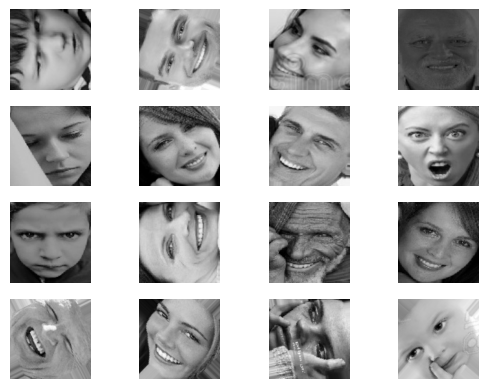

In [11]:
for img,labels in train_df.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(img[i]/255.)
        plt.axis("off")

plt.savefig('Images.png')

In [12]:
train_df = (train_df.prefetch(tf.data.AUTOTUNE))
val_df = (val_df.prefetch(tf.data.AUTOTUNE))

In [13]:
resize_rescale_layer = Sequential([
    Resizing(conf["im_size"],conf["im_size"]),
    Rescaling(1./255)
])

In [14]:
model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None,None, 3), ),

    resize_rescale_layer,

    Conv2D(filters = conf['filters'] , kernel_size = conf['kernel_size'], strides = conf['strides'] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),
    MaxPool2D (pool_size = conf["pool_size"], strides= conf['strides']*2),
    Dropout(rate = conf["dropout_rate"] ),

    Conv2D(filters = conf['filters']*2 + 4, kernel_size = conf['kernel_size'], strides = conf['strides'], padding='valid',
          activation = 'relu', kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),
    MaxPool2D (pool_size = conf["pool_size"], strides = conf['strides']*2),

    Flatten(),

    Dense( 100, activation = "relu", kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),
    Dropout(rate = conf["dropout_rate"]),

    Dense( 10, activation = "relu", kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),

    Dense(3, activation = "softmax"),

])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       6,150,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

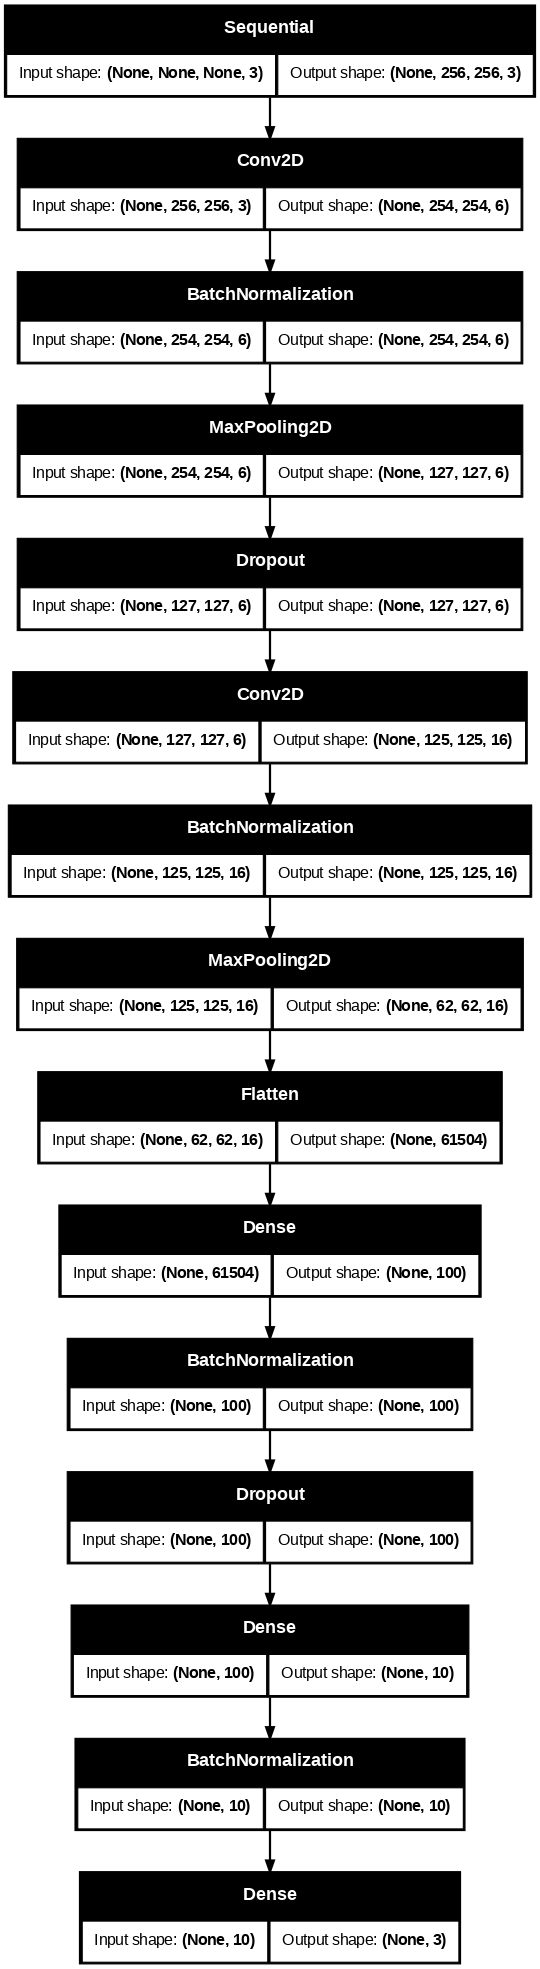

In [16]:
plot_model(model,show_shapes=True,dpi=80)

In [17]:
model.compile(optimizer = Adam(learning_rate=conf['learning_rate']),
              loss = "SparseCategoricalCrossentropy",
              metrics=['accuracy'])

In [18]:
hist = model.fit(train_df,validation_data = val_df,epochs = 15,verbose=1)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.5154 - loss: 1.0483 - val_accuracy: 0.3494 - val_loss: 1.0708
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7161 - loss: 0.6648 - val_accuracy: 0.5500 - val_loss: 0.9266
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8385 - loss: 0.4154 - val_accuracy: 0.7068 - val_loss: 0.7315
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8989 - loss: 0.2895 - val_accuracy: 0.5584 - val_loss: 1.1286
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9335 - loss: 0.1991 - val_accuracy: 0.7441 - val_loss: 0.7641
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9543 - loss: 0.1389 - val_accuracy: 0.7392 - val_loss: 0.8399
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9580 - loss: 0.1179 - val_accuracy: 0.7414 - val_loss: 0.9159
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9709 - loss: 0.0927 - va

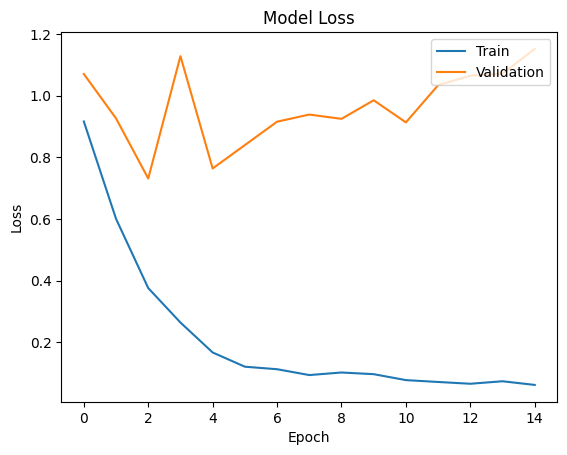

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('model_loss.png')
plt.show()

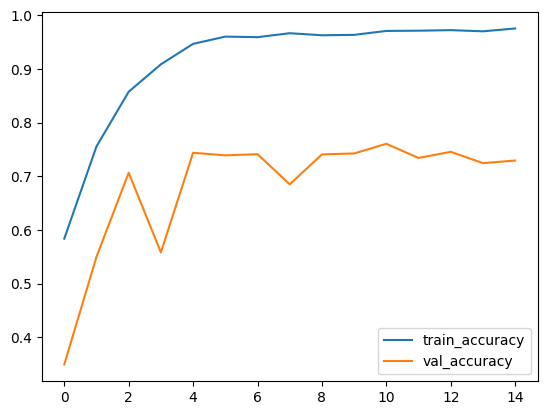

In [21]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train_accuracy',"val_accuracy"])
plt.savefig('model_accuracy.png')
plt.show()

In [22]:
model.evaluate(val_df)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7258 - loss: 1.1903


[1.1521050930023193, 0.7295873761177063]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
sad


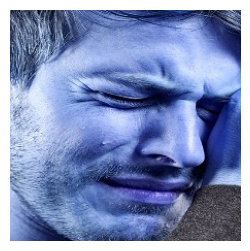

In [24]:
test_img = cv2.imread("/content/dataset/EmotionsDataset_Splitted/data/test/sad/103.jpg")
im = tf.constant(test_img,dtype=tf.float32)
im = tf.expand_dims(im,axis = 0)
print(class_name[tf.argmax(model.predict(im),axis = -1).numpy()[0]])
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(test_img)
plt.show()

In [38]:
model.save('my_model.keras')

In [45]:
import os

model_size = os.path.getsize('/content/model.pkl')
print(f"Model size: {model_size / (1024 * 1024):.2f} MB")

Model size: 70.49 MB


In [46]:
from google.colab import files
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>